# Package Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import torch.optim as optim
import torch.nn.functional as F
import os
from PIL import Image
import pandas as pd

In [4]:
import time
from tqdm.auto import tqdm

for i in tqdm(range(1000)):
    time.sleep(0.01)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Dataset 준비하기

In [6]:
train_dataframe = pd.read_csv('/kaggle/input/2023-final/data.csv')
test_df = pd.read_csv('/kaggle/input/2023-final/testdata.csv')

In [5]:
train_dataframe

,Image,Label,Age,Gender,Race
0,10_0_0_20170103200329407.jpg,0,10,0,0
1,10_0_0_20170103200522151.jpg,0,10,0,0
2,10_0_0_20170103233459275.jpg,0,10,0,0
3,10_0_0_20170110220251986.jpg,0,10,0,0
4,10_0_0_20170110220255346.jpg,0,10,0,0
...,...,...,...,...,...
7335,50_1_3_20170117143102562.jpg,4,50,1,3
7336,50_1_3_20170117154120315.jpg,4,50,1,3
7337,50_1_3_20170117185207623.jpg,4,50,1,3
7338,50_1_4_20170105173053477.jpg,4,50,1,4


In [6]:
test_df

,Image,Gender,Race
0,0_0_20170110220546177.jpg,0,0
1,0_0_20170110225451638.jpg,0,0
2,0_4_20170103200409638.jpg,0,4
3,0_0_20161219154556757.jpg,0,0
4,0_0_20161219154956869.jpg,0,0
...,...,...,...
817,1_0_20170120222640234.jpg,1,0
818,1_1_20170112215232959.jpg,1,1
819,1_1_20170117001143232.jpg,1,1
820,1_2_20170116173220910.jpg,1,2


In [7]:
# 계층화 샘플링 과정(8:2)

from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(train_dataframe, shuffle=True, test_size=0.2, stratify=train_dataframe[['Label', 'Race']])

In [8]:
print(train_df['Label'].value_counts())
print(valid_df['Label'].value_counts())
print(train_df['Race'].value_counts())
print(valid_df['Race'].value_counts())

1    1188
4    1179
3    1169
2    1169
0    1167
Name: Label, dtype: int64
1    297
4    295
0    292
3    292
2    292
Name: Label, dtype: int64
0    2452
1    1091
3     990
2     828
4     511
Name: Race, dtype: int64
0    613
1    272
3    246
2    208
4    129
Name: Race, dtype: int64


In [9]:
for index, row in train_df.iterrows():
    print('Image : {}'.format(row["Image"]))
    print('Label : {}'.format(row["Label"]))
    print('Age   : {}'.format(row["Age"]))
    break

Image : 35_1_0_20170117121850341.jpg
Label : 3
Age   : 35


In [8]:
class CustomDataset(torch.utils.data.Dataset): 
    def __init__(self, dataframe, train='train', transform=None):
        if train == 'train':
            self.image_list = []  # 이미지 list 초기화
            self.label_list = []  # 레이블 초기화
            self.race_list = []   # 인종 초기화
#             self.other_list = []
            path = '/kaggle/input/2023-final/dataset/{}/{}'  # 이미지 경로 지정
            for index, row in dataframe.iterrows():
                image_path = row['Image']   # 이미지 경로 
                image_label = row['Label']  # 이미지 레이블 
                image_age = row['Age']      # 이미지 나이
                image_gender = row['Gender']# 이미지 성별
                image_race = row['Race']    # 이미지 인종
                image = Image.open(path.format(image_label, image_path)).convert('RGB') # RGB로 변환
                # if there is transform, apply transform
                if transform != None:
                    image = transform(image)   # 변환된 이미지 이미지에 적용
                self.image_list.append(image)  # 이미지 list에 이미지 추가
                self.label_list.append(image_label)  # 레이블 list에 이미지 추가
                self.race_list.append(mage_race)  # 인종 list에 이미지 추가
                
        elif train == 'test':
            self.image_list = []
            self.label_list = [] # 이미지의 경로
            self.race_list = [] 
#             self.other_list = []
            path = '/kaggle/input/2023-final/testset/{}'
            for index, row in dataframe.iterrows():
                image_path = row['Image']    # 이미지 경로 
                image_gender = row['Gender'] # 이미지 성별
                image_race = row['Race']     # 이미지 인종
                image = Image.open(path.format(image_path)).convert('RGB')
                if transform != None:
                    image = transform(image)       # 변환된 이미지 이미지에 적용
                self.image_list.append(image)      # 이미지 list에 이미지 추가
                self.label_list.append(image_path) # 레이블 list에 이미지 추가
                self.race_list.append(image_race)  # 인종 list에 이미지 추가
                
    def __len__(self):
        return len(self.image_list)  # 데이터 리스트 길이 반환
    
    def __getitem__(self, idx):
        return self.image_list[idx], self.label_list[idx], self.race_list[idx]  # 이미지, 레이블, 인종 정보 반환

In [9]:
# train_transform에 데이터 증강기법 사용
train_transform = transforms.Compose([transforms.ToTensor(),  # (픽셀이) 0~1사이의 tensor가 존재
                                      transforms.RandomRotation(45),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(p=0.5),# 50%확률로 좌우반전
                                      transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),  # 색감 변화 추가
                                      transforms.RandomVerticalFlip(p=0.5),  # 50%확률로 상하반전
                                      transforms.GaussianBlur(kernel_size=3),# 블러처리
                                      transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])   # 이미지 정규화(평균, 표준편차 0.5)
                                     ])
                                
 # 데이터 증강기법 사용하면 안됨.(사이즈만 맞추기)
test_transform = transforms.Compose([transforms.ToTensor(),  # 이미지 텐서로 변환
                                     transforms.Resize(255),
                                     transforms.CenterCrop(224),
                                     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) 
                                     ])

train_dataset = CustomDataset(train_df, train='train', transform=train_transform)  # train 데이터셋 생성하기
valid_dataset = CustomDataset(valid_df, train='train', transform=test_transform)   # validation 데이터셋 생성하기
test_dataset = CustomDataset(test_df, train='test', transform=test_transform)      # test 데이터셋 생성하기

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


# Dataset에 대한 Data Loaders 구성

In [98]:
batch_size = 50  # 배치 크기
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # train Data Loaders 구성
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)  # validation Data Loaders 구성
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)    # test Data Loaders 구성

In [9]:
for image, label, other in train_loader:
    print(image.shape)
    print(label, label.shape)
    print(other[0])
    print(other[1])
    print(other[2])
    break

torch.Size([64, 3, 224, 224])
tensor([2, 3, 3, 0, 4, 0, 0, 2, 4, 1, 0, 2, 4, 0, 2, 4, 2, 1, 4, 2, 1, 1, 3, 3,
        4, 0, 3, 3, 0, 4, 3, 3, 3, 3, 4, 4, 4, 0, 0, 3, 4, 1, 0, 1, 0, 3, 0, 4,
        1, 1, 3, 3, 1, 0, 3, 4, 4, 0, 2, 3, 3, 1, 4, 3]) torch.Size([64])
tensor([27, 40, 35,  8, 42,  2,  1, 25, 49, 18,  2, 30, 48,  2, 24, 42, 28, 18,
        45, 30, 18, 12, 34, 35, 42,  2, 36, 37,  2, 45, 40, 32, 35, 38, 45, 45,
        41,  1,  1, 38, 41, 11,  1, 11,  8, 40,  8, 45, 15, 16, 32, 35, 15,  1,
        32, 45, 47,  1, 26, 32, 32, 17, 42, 38])
tensor([0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
        0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0])
tensor([1, 0, 0, 4, 3, 0, 0, 1, 3, 1, 0, 2, 1, 4, 1, 4, 3, 2, 0, 1, 0, 4, 2, 0,
        0, 0, 1, 3, 0, 1, 0, 2, 4, 0, 0, 0, 4, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 3, 4, 3, 3, 1, 3, 0, 3, 0, 1, 0, 2, 0])


In [10]:
for image, path, other in test_loader:
    print(image.shape)
    print(path, len(path))
    print(other[0])
    print(other[1])
    break

torch.Size([64, 3, 224, 224])
('1_0_20170109212530499.jpg', '1_3_20161219224922904.jpg', '0_0_20170117185152073.jpg', '1_2_20170116192946857.jpg', '0_0_20170117155008266.jpg', '0_0_20170117145758955.jpg', '0_1_20170113190349585.jpg', '0_0_20170110232257182.jpg', '0_4_20170104000927484.jpg', '1_3_20170117150530668.jpg', '0_3_20170119200245532.jpg', '0_0_20170110231703804.jpg', '0_3_20161219230224536.jpg', '0_3_20161220145820446.jpg', '1_0_20170109193957869.jpg', '1_0_20170109190516025.jpg', '1_0_20170105000634011.jpg', '1_2_20170105183412088.jpg', '0_1_20170113183153677.jpg', '0_2_20170110224711687.jpg', '0_0_20170117190157234.jpg', '0_1_20170105172620093.jpg', '1_4_20170104165850314.jpg', '1_2_20161219151151323.jpg', '0_1_20170113174858707.jpg', '1_2_20170116174850070.jpg', '1_1_20170112215205776.jpg', '1_0_20170109193930338.jpg', '0_0_20170117200045150.jpg', '0_0_20170117123744051.jpg', '1_2_20161219221140063.jpg', '0_0_20170110225232046.jpg', '0_0_20170104204438250.jpg', '0_1_2017011

# Image 확인

In [15]:
classes = ['1 ~ 10', '11 ~ 20', '21 ~ 30', '31 ~ 40', '41 ~ 50']

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))

torch.Size([20, 3, 200, 200]) torch.Size([20])


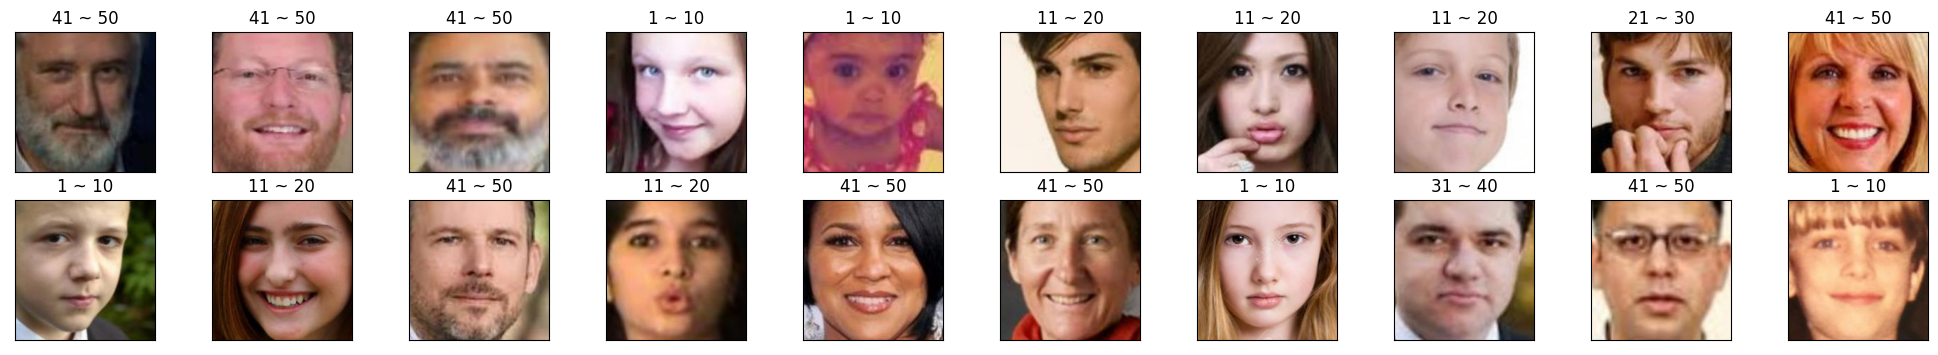

In [16]:
data, label, race =  next(iter(train_loader))  # train_loader에서 데이터, 레이블, 인종 정보 가져오기
print(data.shape, label.shape)

fig = plt.figure(figsize=(25, 4))  # 사진 크기 설정
# display 20 images
data = data.numpy() # 넘파이로 변환
for idx in np.arange(20):  # 20개 사진 출력
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])  # 사진 위치 지정
    imshow(data[idx])
    ax.set_title(classes[label[idx]])  # 타이틀 설정

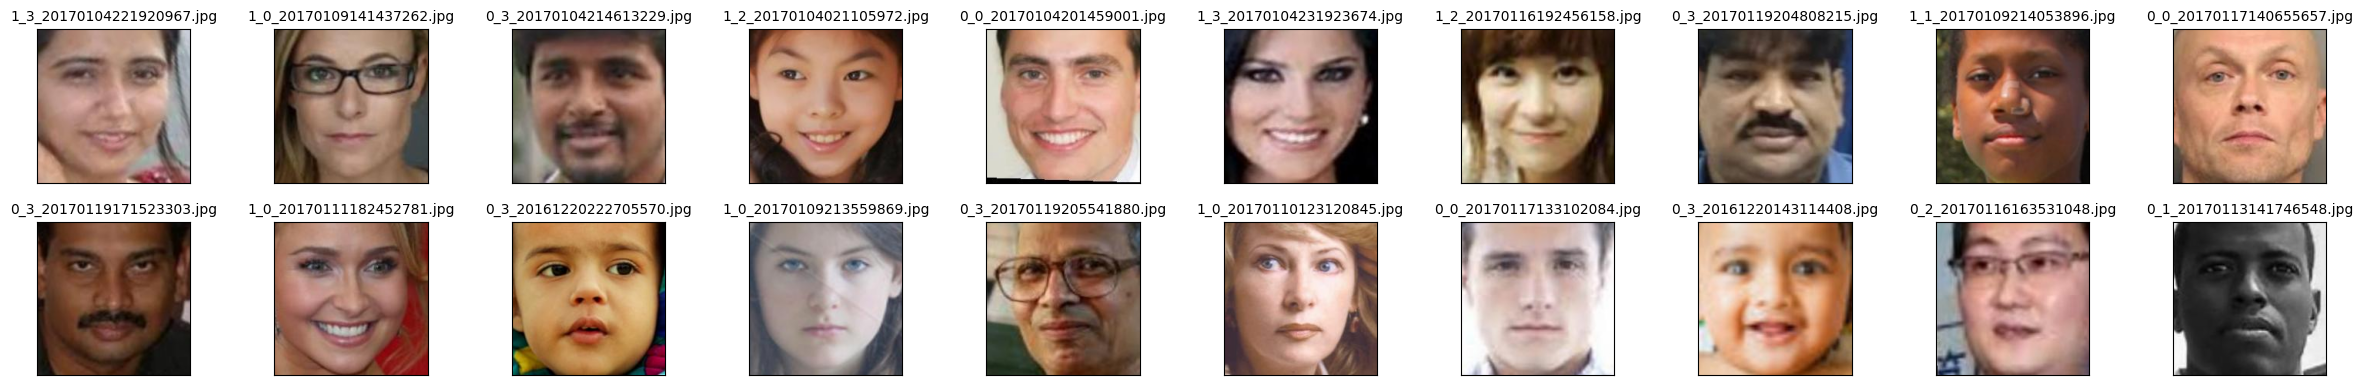

In [17]:
image, file_name, race = next(iter(test_loader))  # train_loader에서 데이터, 레이블, 인종 정보 가져오기
image.shape, len(file_name)

fig = plt.figure(figsize=(25, 4))  # 사진 크기 설정
# display 20 images
image = image.numpy()   # 넘파이로 변환
for idx in np.arange(20):  # 20개 사진 출력
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[]) # 사진 위치 지정
    imshow(image[idx])
    ax.set_title(file_name[idx], fontsize = 10) # 타이틀 설정
    fig.tight_layout()

# Model 설정

In [111]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # convolutional layer
        # 첫번째 레이어에는 배치 정규화X -> 첫 번째 레이어가 입력 이미지를 처리하기 전에 이미지 전처리 과정에서 이미 정규화되었기 때문.
        # 3채널을 입력받은 후 16개의 채널을 출력하는 합성곱 레이어, 커널(필터)의 크기는 3x3
        self.conv1 = nn.Conv2d(3, 64, (3,3), stride = (1,1), padding = (1,1))  # nn.Conv2d(입력채널수, 출력채널수, 필터의 크기, stride, padding)
      
        # convolutional layer
        # 64채널을 입력받은 후 128개의 채널을 출력하는 합성곱 레이어, 커널(필터)의 크기는 3x3
        self.conv2 = nn.Conv2d(64, 128, (3,3), stride = (1,1), padding = (1,1))
        self.bn2 = nn.BatchNorm2d(128)  # BatchNorm2d 추가
        
        # convolutional layer 
        # 128채널을 입력받은 후 256개의 채널을 출력하는 합성곱 레이어, 커널(필터)의 크기는 3x3
        self.conv3 = nn.Conv2d(128, 256, (3,3), stride = (1,1), padding = (1,1))
        self.bn3 = nn.BatchNorm2d(256)  # BatchNorm2d 추가
        
        # 레이어 추가
        # 256채널을 입력받은 후 512개의 채널을 출력하는 합성곱 레이어, 커널(필터)의 크기는 3x3
        self.conv4 = nn.Conv2d(256, 512, (3,3), stride = (1,1), padding = (1,1))
        self.bn4 = nn.BatchNorm2d(512)  # BatchNorm2d 추가
        
        # 512채널을 입력받은 후 1024개의 채널을 출력하는 합성곱 레이어, 커널(필터)의 크기는 3x3
        self.conv5 = nn.Conv2d(512, 1024, (3,3), stride = (1,1), padding = (1,1))
        self.bn5 = nn.BatchNorm2d(1024)  # BatchNorm2d 추가
        
        # 1024채널을 입력받은 후 2048개의 채널을 출력하는 합성곱 레이어, 커널(필터)의 크기는 3x3
        self.conv6 = nn.Conv2d(1024, 2048, (3,3), stride=(1,1), padding=(1,1))
        self.bn6 = nn.BatchNorm2d(2048)
        
        # max pooling layer
        self.pool = nn.MaxPool2d(2, stride = 2)  # nn.MaxPool2d(필터크기, stride)
        self.poolA = nn.AvgPool2d(2, stride = 2) # 평균 풀링
        # linear layer (18432 -> 500)
        self.fc1 = nn.Linear(18432, 500)  # 18432개의 입력을 받은 후 500개를 출력하는 fully connected layer
        # linear layer (500 -> 5)
        self.fc2 = nn.Linear(500, 5)      # 500개의 입력을 받은 후 5개를 출력하는 fully connected layer

        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.5) # 드롭아웃 50% 적용
        self.relu = nn.ReLU(True)      # ReLU 활성화 함수 적용

    def forward(self, x, race):
        # add sequence of convolutional and max pooling layers
        x = self.pool(self.relu(self.conv1(x)))              # 합성곱에 ReLU활성화 함수 씌운 후 풀링
        x = self.pool(self.relu(self.bn2(self.conv2(x))))    # 합성곱에 배치 정규화 적용하고 ReLU활성화 함수 씌운 후 최대 풀링
        x = self.pool(self.relu(self.bn3(self.conv3(x))))    # 합성곱에 배치 정규화 적용하고ReLU활성화 함수 씌운 후 최대 풀링
        #추가
        x = self.pool(self.relu(self.bn4(self.conv4(x))))    # 합성곱에 배치 정규화 적용하고 ReLU활성화 함수 씌운 후 최대 풀링
        x = self.pool(self.relu(self.bn5(self.conv5(x))))    # 합성곱에 배치 정규화 적용하고 ReLU활성화 함수 씌운 후 최대 풀링
        x = self.poolA(self.relu(self.bn6(self.conv6(x))))   # 합성곱에 배치 정규화 적용하고 ReLU활성화 함수 씌운 후 평균 풀링
        
        # flatten image input
        x = x.reshape(x.size(0), -1)  # 2차원 텐서를 1차원으로 펼치기
        # add dropout layer
        x = self.dropout(x)  # 드롭 아웃 적용(과적합 방지)
        
        # add 1st hidden layer, with relu activation function
        # 컨볼루션 레이어와 풀링 레이어는 비선형성을 가지고 있지만, 선형 레이어인 fully connected layer는 선형 변환만 수행하므로 비선형성을 가지지 않습니다.
        x = self.relu(self.fc1(x))  #  fully connected layer 이후에 비선형성을 도입하기 위함
        # add dropout layer
        x = self.dropout(x)
        # last hidden layer, no activation function
        x = self.fc2(x) 
        
        # 마지막 레이어 이후에 인종 정보를 특성들과 연결
        race = race.view(race.size(0), -1) # reshape race tensor
        x = torch.cat((x, race), dim=1)    # concatenate x and race
        
        return x

# create a complete CNN(인스턴스 생성)
model = ConvNet()

# move tensors to GPU if CUDA is available(GPU로 가게 해준다)
model.to(device)

ConvNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(1024, 2048, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Cost 함수 및 Optimzer 설정

In [112]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# 손실 함수(criterion) 정의
criterion = nn.CrossEntropyLoss()
# Adam 사용 / L2정규화 추가
weight_decay = 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)


## 스케줄러 정의

# 동적감소 스케줄링
# 검증 손실이 더 이상 개선되지 않을 때 학습률을 감소
# scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.95, verbose=True)

# 주기적감소 스케줄링
# 코사인 함수를 사용하여 학습률을 주기적으로 감소
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50,eta_min=0) # T_max 값이 클수록 더 많은 epoch 동안 학습률이 감소

# 지수적감소 스케줄링
import torch.optim.lr_scheduler as lr_scheduler
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95) # gamma를 작게하면 학습 매우 느림(정확도 변하지 X)

# 단계적감소 스케줄링
from torch.optim.lr_scheduler import StepLR
# scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # 매 10번째 epoch마다 학습률이 0.1배로 줄어든다.

# step_size : 작은 값은 더 자주 학습률을 조정하고, 큰 값은 더 드물게 조정한다.(주로 10~50값 사용)
# gamma : 작은 값은 더 강한 감소를 의미. 작은 값은 학습률을 더욱 급격하게 감소시키므로 모델을 더욱 세밀하게 조정 가능. But 너무 작으면 최적점에 도달 X
#감소 비율 gamma (새로운 학습률 = 이전 학습률 * 감소 비율)

# Train and Validation

In [113]:
# number of epochs to train the model
n_epochs = 30

# 현재까지의 최소 검증 손실값을 추적
valid_loss_min = np.Inf # track change in validation loss

# keep track of training and validation loss
train_loss = torch.zeros(n_epochs) # train_loss를 epoch별로 저장
valid_loss = torch.zeros(n_epochs)

train_acc = torch.zeros(n_epochs)
valid_acc = torch.zeros(n_epochs)


for e in range(0, n_epochs):

   
    ###################
    # train the model #
    ###################
    model.train()  # 학습 과정
    for data, labels, race in train_loader:
        # move tensors to GPU if CUDA is available
        data, labels, race = data.to(device), labels.to(device), race.to(device)
        
        optimizer.zero_grad()  # 그래디언트 초기화
        logits = model(data, race)  # 구현한 모델을 통한 예측 logit
        # calculate the batch loss 
        loss = criterion(logits, labels)  # 손실값 계산
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()  # 역전파 수행
        # perform a single optimization step (parameter update)
        optimizer.step() # 가중치 업데이트
        # update training loss
        train_loss[e] += loss.detach().cpu().item()  # 학습 손실값 저장
        
        ps = F.softmax(logits, dim=1)  # 확률로 바꿔줌
        top_p, top_class = ps.topk(1, dim=1)  # 몇 번째 class가 가장 높은 확률인지?
        equals = top_class == labels.reshape(top_class.shape)  # label이랑 비교해서 몇개를 맞췄는지 세는 것
        train_acc[e] += torch.mean(equals.type(torch.float)).detach().cpu()  # float로 캐스팅해준 후 mean을 해서 평균을 구한다.
        
        # trainig과정에서는 gpu연산을 해야한다. 연산 다 끝나고 결과치들은 다 cpu로 가져온다.
        # cpu로 바꿔주는 이유는 나중에 그래프 그릴 때, gpu는 지원되지 않기 때문에
    
    train_loss[e] /= len(train_loader) # 평균 학습 손실값 계산
    train_acc[e] /= len(train_loader)  # 평균 학습 정확도 계산
        
        
    ######################    
    # validate the model #
    ######################
    with torch.no_grad():  
        model.eval()  # dropout을 꺼라. -> 모델 평가할 때는 드롭아웃 비활성화
        for data, labels, race in valid_loader:
            # move tensors to GPU if CUDA is available
            data, labels, race = data.to(device), labels.to(device), race.to(device)  # 같은 장치로 이동시켜주기
            # forward pass: compute predicted outputs by passing inputs to the model
            logits = model(data, race)   # 구현한 모델을 통한 예측 logit
            # calculate the batch loss
            loss = criterion(logits, labels)   # 손실값 계산
            # update average validation loss 
            valid_loss[e] += loss.detach().cpu().item()  # 정확도 저장

            ps = F.softmax(logits, dim=1)   # 소프트 맥스 함수 적용 -> 클래스별 확률 계산
            top_p, top_class = ps.topk(1, dim=1)    # 가장 높은 확률 클래스 선택
            equals = top_class == labels.reshape(top_class.shape)       # 실제 레이블, 예측 레이블 비교
            valid_acc[e] += torch.mean(equals.type(torch.float)).detach().cpu()    # 정확도 계산
    
    # calculate average losses
    valid_loss[e] /= len(valid_loader)  # 평균 검증 손실값 계산
    valid_acc[e] /= len(valid_loader)   # 평균 검증 정확도 계산
    
    # update learning rate
#     scheduler.step(valid_loss[e])
    scheduler.step()  # 학습 스케줄러 업데이트
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e, train_loss[e], valid_loss[e]))
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining accuracy: {:.6f} \tValidation accuracy: {:.6f}'.format(
        e, train_acc[e], valid_acc[e]))
    
    # save model if validation loss has decreased
    if valid_loss[e] <= valid_loss_min:  # val_loss가 가장 최근에 저장하고 있는 min보다 작으면
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss[e]))
        torch.save(model.state_dict(), 'my_model.pt')  # 현재 모델 저장
        valid_loss_min = valid_loss[e]  # 최소 검증 손실값 업데이트

Epoch: 0 	Training Loss: 1.939955 	Validation Loss: 1.549146
Epoch: 0 	Training accuracy: 0.217319 	Validation accuracy: 0.324667
Validation loss decreased (inf --> 1.549146).  Saving model ...
Epoch: 1 	Training Loss: 1.609577 	Validation Loss: 1.525852
Epoch: 1 	Training accuracy: 0.250817 	Validation accuracy: 0.260444
Validation loss decreased (1.549146 --> 1.525852).  Saving model ...
Epoch: 2 	Training Loss: 1.592079 	Validation Loss: 1.505106
Epoch: 2 	Training accuracy: 0.258583 	Validation accuracy: 0.314148
Validation loss decreased (1.525852 --> 1.505106).  Saving model ...
Epoch: 3 	Training Loss: 1.578199 	Validation Loss: 1.475112
Epoch: 3 	Training accuracy: 0.271988 	Validation accuracy: 0.330445
Validation loss decreased (1.505106 --> 1.475112).  Saving model ...
Epoch: 4 	Training Loss: 1.572285 	Validation Loss: 1.486284
Epoch: 4 	Training accuracy: 0.262311 	Validation accuracy: 0.324444
Epoch: 5 	Training Loss: 1.559223 	Validation Loss: 1.459554
Epoch: 5 	Training

In [66]:
# 모델 자체를 저장
torch.save(model, 'my_model_save.pt')

# 모델 불러오기
model_load = torch.load('model_save.pt')

# Loss 분석(그래프 시각화)

In [3]:
model = ConvNet()  # 모델 인스턴스 생성
model.load_state_dict(torch.load('my_model.pt'))

NameError: name 'ConvNet' is not defined

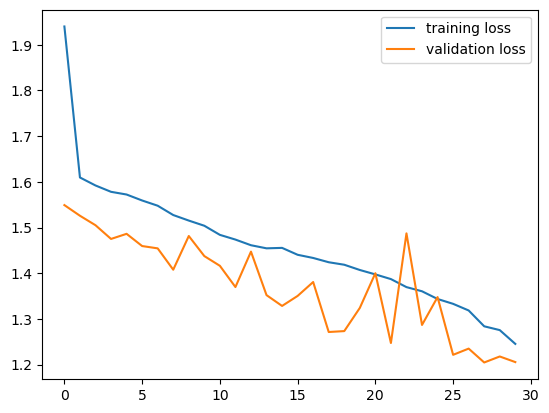

In [114]:
# 손실값 그래프 시각화

import matplotlib.pyplot as plt

plt.plot(train_loss, label = 'training loss')
plt.plot(valid_loss, label = 'validation loss')
plt.legend()

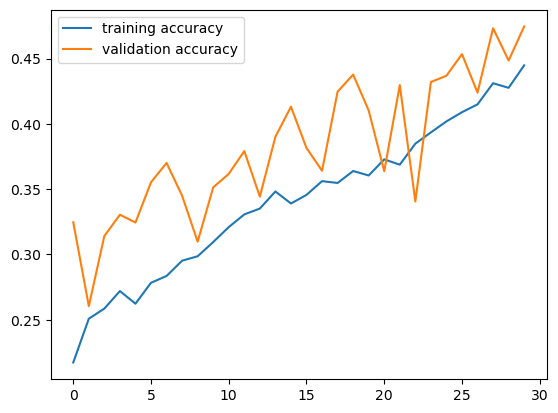

In [115]:
# 정확도 그래프 시각화

plt.plot(train_acc, label = 'training accuracy')
plt.plot(valid_acc, label = 'validation accuracy')
plt.legend()

# 결과 CSV 생성

In [ ]:
id_list = []   # 예측 ID 저장할 리스트
pred_list = [] # 예측 카테고리 저장할 리스트
with torch.no_grad(): 
    model.eval()  # 모델 평가 모드
    for data, file_name, race in test_loader:
        data, race = data.to(device), race.to(device)  # 데이터와 인종정보를 GPU로 이동
        logits = model(data, race)  # 예측 출력 계산
        
        ps = F.softmax(logits, dim=1)        # 예측 확률 계산(소프트맥스 함수)
        top_p, top_class = ps.topk(1, dim=1) # 가장 높은 확률을 가진 예측한 클래스 선택
        
        id_list += list(file_name)  # 실제값 저장
        pred_list += top_class.view(-1).tolist() # 예측값 저장

# 예측 결과 데이터 프레임으로 생성
handout_result = pd.DataFrame({'Id':id_list, 'Category':pred_list})
# 결과를 csv파일로 저장
handout_result.to_csv('./result.csv', index=False) 

In [ ]:
# handout_result['Category'] = torch.ones(handout_result['Category'].shape, dtype=torch.int)*5
handout_result

# 참고 자료

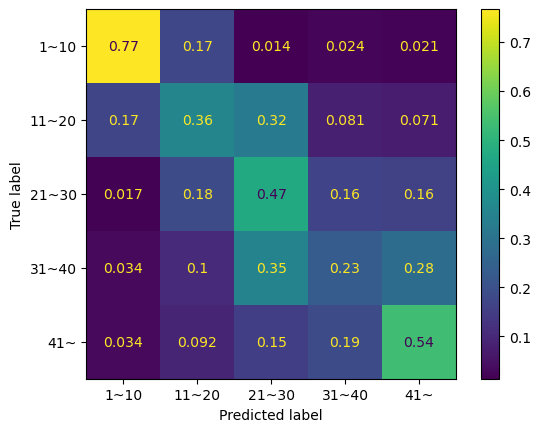

Test accuracy : 47.275203704833984


In [116]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
classes=['1~10', '11~20', '21~30', '31~40', '41~']
classes_cm=[0, 1, 2, 3, 4]  # 클래스 레이블
test_loss = 0
y_pred = []  # 예측값 리스트 초기화
y_true = []  # 실제 정답 리스트 초기화
test_acc = 0
with torch.no_grad(): 
    model.eval()
    for data, labels, race in valid_loader:
        # move tensors to GPU if CUDA is available
        data, labels, race = data.to(device), labels.to(device), race.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        logits = model(data, race)
        # calculate the batch loss
        loss = criterion(logits, labels)
        # update average test loss 
        test_loss += loss.item()

        top_p, top_class = logits.topk(1, dim=1)   # 가장 높은 확률, 해당 클래스 추출
        y_pred.extend(top_class.data.cpu().numpy()) # 예측된 클래스 y_pred에 추가
        y_true.extend(labels.data.cpu().numpy())    # 실제 클래스 y_true에 추가
        equals = top_class == labels.reshape(top_class.shape)
        test_acc += torch.sum(equals.type(torch.float)).detach().cpu()
        
    test_acc/=len(valid_loader.dataset)  # 평균 테스트 정확도 계산
    test_acc*=100  # 백분율 변환
    
cm = confusion_matrix(y_true, y_pred, labels=classes_cm, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
plt.show()
print('Test accuracy : {}'.format(test_acc))